In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time

In [2]:
rootfolder = '..'


Useful function for plot the dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set all the paramters for the anomaly detection

In [4]:
# patch size (tha patch is square)
p = 15

# number of patches in the training set for dictionary learning
npatch_dictionary = 10000

# number of patches to estimate the confidence region
npatch_region = 1000

# paramters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

In [5]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}/data/img_normal.png') / 255

# extract random patches from the image and store them in a matrices S, V
S = np.zeros((p**2, npatch_dictionary))
V = np.zeros((p**2, npatch_dictionary))

# extract npatch random pxp (flattened to M) patches from the image
for i in range(npatch_dictionary):
    x = np.random.randint(0, img.shape[0] - p)
    y = np.random.randint(0, img.shape[1] - p)
    S[:, i] = img[x:x+p, y:y+p].flatten()

for i in range(npatch_region):
    x = np.random.randint(0, img.shape[0] - p)
    y = np.random.randint(0, img.shape[1] - p)
    V[:, i] = img[x:x+p, y:y+p].flatten()

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [6]:
# PREPROCESSING: exclude black patches from S
print(S.shape)
v = np.median(S, axis=0)
S = S[:,v > 0.06]
print(S.shape)

(225, 10000)
(225, 9446)


In [7]:
# PREPROCESSING: remove the mean from each patch
S = S - np.mean(S, axis=0)


Perform dictionary learning via KSVD or MOD

In [8]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  # residual
  r = s - D @ x

  # support set
  omega = [] 
  
  while np.linalg.norm(r) > tau and len(omega) < L:
    # SWEEP STEP
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (r.T @ dj)**2 / np.linalg.norm(dj)**2

    # find the column of D that matches best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega:
        omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s||
    D_omega = D[:, omega]
    x_w, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)
    for j, w in zip(omega, x_w.flatten()): 
        x[j] = w

    # update the residual
    r = s - D @ x

  return x

In [9]:
'''
# number of columns of the dictionary
N = S.shape[1]

# intialize the dictionary
D = np.random.rand(p**2, N)

# normalize each column of D (zero mean and unit norm)
D -= np.mean(D, axis=0)
norms = np.linalg.norm(D, axis=0)
D /= norms

# number of iteration of the KSVD
max_iter = 5

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, S.shape[1]))


for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(S.shape[1]):
      X[:, n] = OMP(S[:, n], D, L, 1e-3)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.nonzero(X[j, :])[0]

        if len(omega) == 0:
            D[:, j] = np.random.rand(p**2)
            D[:, j] -= D[:, j].mean()  # Remove mean
            D[:, j] /= np.linalg.norm(D[:, j])  # Normalize
        else:
            # compute the residual matrix E, ignoring the j-th atom
            E = S - (D @ X - np.outer(D[:, j], X[j, :]))

            # restrict E to the columns indicated by omega
            Eomega = E[:, omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

            # update the dictionary
            D[:, j] = U[:, 0]

            # update the coefficient matrix
            X[j, omega] = Sigma[0] * V[0, :]
    
    time_end = time.time()
    print(f'{time_end - time_start:.0f}')
'''
# or load a precomputed dictionary
D = loadmat(f'{rootfolder}/data/dict_anom_det.mat')['D']

Show the learned dictionary

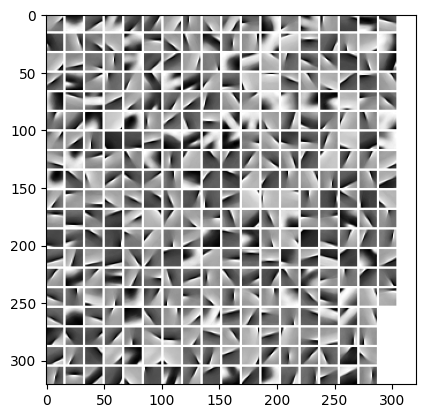

In [10]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [11]:
# PREPROCESSING: exclude black patches
print(V.shape)
v = np.median(V, axis=0)
V = V[:,v > 0.06]
print(V.shape)

(225, 10000)
(225, 947)


In [12]:
# PREPROCESSING: remove the mean from each patch
V = V - np.mean(V, axis=0)

In [13]:
# sparse coding of each patch in V
X = np.zeros((natom, V.shape[1]))
for i in range(V.shape[1]):
  X[:, i] = OMP(V[:, i], D, L, 1e-3)

In [14]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

A = np.zeros((2, V.shape[1]))     # each column contains the values of the anomaly_scores for a patch

for i in range(V.shape[1]):
  A[:,i] = [np.linalg.norm(X[:,i], ord=1), np.linalg.norm(V[:,i] - D @ X[:,i])]

# Estimation of mean and covariance
mu = np.mean(A, axis=1)
Sigma = np.cov(A)


In [15]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.05

# compute the mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
  mahal_dist[i] = sp.spatial.distance.mahalanobis(A[:,i], mu, np.linalg.inv(Sigma))

# set the threshold
threshold = np.percentile(mahal_dist, 100*(1-FPR_target))
threshold

2.3715489825572416

## Test phase

In [16]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255

imsz = img_test.shape

STEP = 4
# initialize the estimated image
heatmap = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [17]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img_test[i:i+p, j:j+p].flatten()

        # if the median of s is to small set the anomaly score to 0:
        if np.median(s) <= 0.06:
            score = 0
        else:
            # subratct the mean to the patch
            s = s - np.mean(s)

            # perform the sparse coding
            x = OMP(s, D, L, 1e-3)

            # compute the anomaly indicators vector
            a = np.array([np.linalg.norm(x, ord=1), np.linalg.norm(s - D @ x)])

            # compute the anomaly score
            score = sp.spatial.distance.mahalanobis(a, mu, np.linalg.inv(Sigma))

        # update the heatmap
        heatmap[i:i+p, j:j+p] += score

        # update the weight matrix
        weights[i:i+p, j:j+p] += 1


In [18]:
# normalize the heatmap
heatmap = heatmap / weights

/var/folders/8g/fgfxv9zs0mqf54m85lvfshww0000gn/T/ipykernel_2757/3950609915.py:2: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / weights


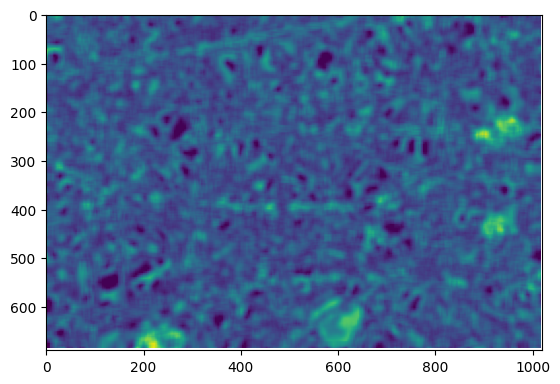

In [19]:
# plot the heatmap
plt.imshow(heatmap)

In [20]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = heatmap > threshold


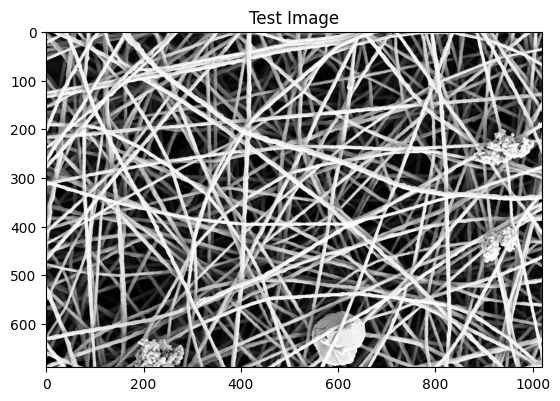

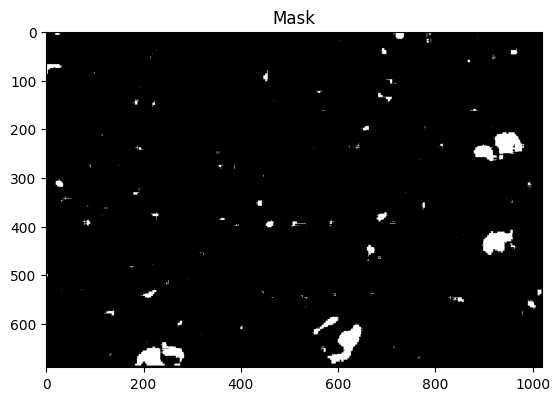

In [21]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

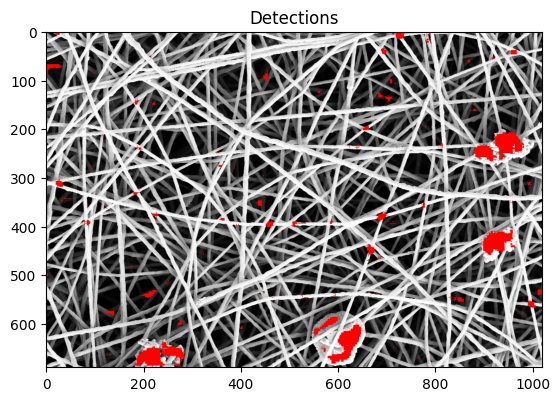

In [22]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,2] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()